In [312]:
%matplotlib inline
from deco.imports import *
from deco.context import *
import json
from pprint import pprint
import sklearn.ensemble as st
from datetime import datetime
import random
from math import sin, cos, sqrt, atan2, radians
import networkx as nx
import numpy as np

In [2]:
PATH = '/home/rotem/Documents/code/optimization-course/'

In [3]:
def coordinates_distance(lat1, lon1, lat2, lon2):
    R = 6373.0
    lat1 = radians(float(lat1))
    lon1 = radians(float(lon1))
    lat2 = radians(float(lat2))
    lon2 = radians(float(lon2))

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    return distance

In [204]:
df = pd.read_csv(PATH + 'trip_data_1.csv', error_bad_lines=False, warn_bad_lines=False, nrows=1)

In [40]:
df

,medallion,hack_license,vendor_id,rate_code,store_and_fwd_flag,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
0,89D227B655E5C82AECF13C3F540D4CF4,BA96DE419E711691B9445D6A6307C170,CMT,1,N,2013-01-01 15:11:48,2013-01-01 15:18:10,4,382,1.0,-73.978165,40.757977,-73.989838,40.751171
1,0BD7C8F5BA12B88E0B67BED28BEA73D8,9FD8F69F0804BDB5549F40E9DA1BE472,CMT,1,N,2013-01-06 00:18:35,2013-01-06 00:22:54,1,259,1.5,-74.006683,40.731781,-73.994499,40.750660
2,0BD7C8F5BA12B88E0B67BED28BEA73D8,9FD8F69F0804BDB5549F40E9DA1BE472,CMT,1,N,2013-01-05 18:49:41,2013-01-05 18:54:23,1,282,1.1,-74.004707,40.737770,-74.009834,40.726002
3,DFD2202EE08F7A8DC9A57B02ACB81FE2,51EE87E3205C985EF8431D850C786310,CMT,1,N,2013-01-07 23:54:15,2013-01-07 23:58:20,2,244,0.7,-73.974602,40.759945,-73.984734,40.759388
4,DFD2202EE08F7A8DC9A57B02ACB81FE2,51EE87E3205C985EF8431D850C786310,CMT,1,N,2013-01-07 23:25:03,2013-01-07 23:34:24,1,560,2.1,-73.976250,40.748528,-74.002586,40.747868
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2999995,FF5AC438A53E91D55EF4AC11FB6AA649,BF3FC77DBC488D7264AAC3690E2D574F,CMT,1,N,2013-01-06 06:59:44,2013-01-06 07:06:00,1,375,0.8,-73.985443,40.752293,-73.996155,40.755833
2999996,CD99467D8FB77951D737FC1E44D3D66A,88E117F47AD8901F5EDD15D5E3AE15B4,CMT,1,Y,2013-01-06 21:33:08,2013-01-06 21:36:55,1,226,1.2,-73.963844,40.802929,-73.966850,40.789207
2999997,7ACFC9C63DF8479CD974AEB0D55C2410,3FA0CC5BADBAF18E4012537BCDC499D2,CMT,1,N,2013-01-06 21:33:17,2013-01-06 21:38:24,1,306,2.2,-73.955284,40.776932,-73.934601,40.803185
2999998,6CAC509D6839F4ED44901BD8C0A666A8,C12B58E6CED695C8C8267D28F72CA12A,CMT,1,N,2013-01-06 14:20:23,2013-01-06 14:24:35,2,251,1.2,-73.987244,40.771065,-73.969254,40.767384


In [38]:
# df.pickup_longitude = df.pickup_longitude.round(4)
# df.pickup_latitude = df.pickup_latitude.round(4)
# df.dropoff_longitude = df.dropoff_longitude.round(4)
# df.dropoff_latitude = df.dropoff_latitude.round(4)
df = df[(df.pickup_latitude >= 40.739660) & (df.pickup_latitude <= 40.747118) &
  (df.pickup_longitude >= -74.002510) & (df.pickup_longitude <= -73.981546)]

In [35]:
def filter_close_by(df, lat='pickup_latitude', long='pickup_longitude', count='trip_distance', max_distance=0.08, df_all=None):
    df_all = df if df_all is None else df_all
    org_a = df[[lat, long, count]].groupby([lat, long], as_index=False).count()
    org_b = df_all[[lat, long, count]].groupby([lat, long], as_index=False).count()
    res = []
    for row in org_a.values:
        for other in org_b.values:
            distance = coordinates_distance(row[0], row[1], other[0], other[1])
            if distance <= max_distance and distance > 0:
                res.append([row[0], row[1], other[0], other[1], distance, row[2], other[2], 1])
    distances = pd.DataFrame(res, columns=['lat1', 'long1', 'lat2', 'long2', 'distance', 'w1', 'w2', 'count'])
    return distances

In [36]:
def sort_by_weight(distances):
    distances_agg = distances.groupby(['lat1', 'long1'], as_index=False)\
                    .agg({'w2': 'sum', 'distance': 'mean', 'w1': 'max', 'count': 'sum'})
    distances_agg['weight'] = distances_agg.w1 + distances_agg.w2
    distances_agg = distances_agg.sort_values(['weight'], ascending=False)
    return distances_agg

In [37]:
def get_dataset_by_centroid(df, long, lat):
    columns = [lat, long]
    top = []
    # sample dataset to find strong coordinates
    for i in range(300):
        try:
            distances = filter_close_by(df.sample(100), lat, long)
            top.append(sort_by_weight(distances).head(5))
        except: pass
    
    # find strongest among the strong coordinates
    topp = pd.concat(top)
    topp = sort_by_weight(filter_close_by(topp, 'lat1', 'long1', 'count')).head(5)
    display(topp)
    topp = topp[['lat1', 'long1']]
    topp.columns = columns
    # keep the strongest
    center = topp.head(1)
    
    # find anything close to the strongest in the original data
    d = df.merge(center, on=columns)
    f = filter_close_by(d, df_all=df)    
    # union the coordinates we got to one dataset
    best_ones1 = f[['lat1', 'long1']]
    best_ones2 = f[['lat2', 'long2']]
    best_ones1.columns = columns
    best_ones2.columns = columns
    pickup_points = pd.concat([best_ones1, best_ones2],).drop_duplicates()
    
    # return anything nearby the center
    final = df.merge(pickup_points, on=columns)
    return final

In [41]:
# final = pd.read_csv(PATH + 'trip_from_pickup.csv')
final = get_dataset_by_centroid(df, 'pickup_longitude', 'pickup_latitude')
get_dataset_by_centroid(final, 'dropoff_longitude', 'dropoff_latitude')

,lat1,long1,w2,distance,w1,count,weight
873,40.749886,-73.991714,73.0,0.040857,1.0,73,74.0
889,40.750019,-73.991585,73.0,0.038468,1.0,73,74.0
888,40.750011,-73.991577,73.0,0.038303,1.0,73,74.0
858,40.749802,-73.991463,73.0,0.040969,1.0,73,74.0
864,40.749836,-73.991455,73.0,0.039849,1.0,73,74.0


,lat1,long1,w2,distance,w1,count,weight
972,40.752678,-73.979187,90.0,0.045059,2.0,73,92.0
981,40.752819,-73.979210,90.0,0.047446,1.0,72,91.0
959,40.752575,-73.979424,90.0,0.044275,1.0,72,91.0
949,40.752460,-73.979439,87.0,0.046167,3.0,71,90.0
965,40.752659,-73.979317,86.0,0.042476,3.0,70,89.0


,medallion,hack_license,vendor_id,rate_code,store_and_fwd_flag,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
0,171FD91CBF0D6FABF499A9452A4950D5,91FAD514BC3A214E6ADFB329565EF4BE,VTS,1,NaN,2013-01-13 07:20:00,2013-01-13 07:21:00,1,60,0.30,-73.991913,40.750301,-73.991913,40.750301
1,E4823C782909E00D2D1BDB81F3C905DA,D16C244384652116064C44540031EF83,VTS,1,NaN,2013-01-05 20:22:00,2013-01-05 20:23:00,1,60,0.00,-73.991371,40.749912,-73.991356,40.749771
2,D4A54111A17ADEAFF0BFC77E1D3BBE30,8E2A9E6F9B918A88E4A75FAD48FACE2F,VTS,1,NaN,2013-01-13 10:39:00,2013-01-13 10:40:00,1,60,0.43,-73.991493,40.749928,-73.991493,40.749928
3,96F67FB36A356A23CF553618CB48D84E,F06D50B50E13D32FAB4C93204E401755,VTS,1,NaN,2013-01-13 12:27:00,2013-01-13 12:46:00,1,1140,0.92,-73.991280,40.750298,-73.991280,40.750298
4,EA1E031EF04F50863A8E506CEDE22D1F,32A2C31449B2CEABC8DADE189E058295,VTS,1,NaN,2013-01-03 19:34:00,2013-01-03 19:43:00,1,540,1.00,-73.991257,40.750381,-73.991257,40.750381
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,6BD0AFC6EA4F0CC2AA2CCEC78CC95BDD,6270CA21F0F3013DE61039F74C6C225E,CMT,1,N,2013-01-03 07:56:40,2013-01-03 08:02:15,1,335,1.00,-73.991814,40.750343,-73.992081,40.749836
94,CF395613DF8B82E4946ABDD59EF3BBAF,BBA3557676ACE3E141DBAA313E3B2408,CMT,1,N,2013-01-03 11:25:38,2013-01-03 11:31:03,1,325,1.00,-73.992523,40.749783,-73.992523,40.749783
95,D735012737F74B0FC963F5AF9AF53D00,F514C031B250E1445A1C06532410F9C8,CMT,2,N,2013-01-03 23:49:28,2013-01-03 23:49:37,2,8,15.60,-73.991219,40.750195,-73.991219,40.750195
96,C38A76F1FD999C60C372A400C9F01886,1F3D0420AF64D737976DA9BA1FAD8797,CMT,1,N,2013-01-04 12:33:42,2013-01-04 12:38:49,1,307,0.40,-73.991234,40.750065,-73.991234,40.750065


In [42]:
final

,medallion,hack_license,vendor_id,rate_code,store_and_fwd_flag,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
0,E9BA494DC1A1F26D186394EFBB8327CF,BBF604B3A2426BFBAAC982AAAA0BF1B5,CMT,1,N,2013-01-01 18:36:53,2013-01-01 18:39:04,1,131,0.50,-73.992172,40.749954,-73.996750,40.744553
1,2C159C8FCCDE50174CF6CFC07E75F1BA,51C567531541EE45C5EE86E956E46E4C,CMT,1,N,2013-01-07 04:45:14,2013-01-07 04:48:56,1,222,0.90,-73.991936,40.749622,-73.978531,40.751308
2,72427BE07CFC31814826BCE9EB92D8D5,F01341355389BD2DCF5B085EF7F1BED3,VTS,1,NaN,2013-01-02 08:33:00,2013-01-02 08:39:00,5,360,0.78,-73.991936,40.749622,-73.983841,40.743252
3,CD9DEF073BAB75B8B36015D85FD3F777,80430F0667E3C82E63AAF4F0DC547664,CMT,1,N,2013-01-05 03:20:28,2013-01-05 03:43:36,4,1387,11.20,-73.991142,40.750366,-73.984436,40.618481
4,287DBBA18C622BEA67A6EC02414D8C2B,1BF3D3D6DCEB00308A3F0EC0AAA14071,VTS,1,NaN,2013-01-04 19:44:00,2013-01-04 19:59:00,1,900,2.24,-73.991142,40.750366,-73.987572,40.725765
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23704,D28F9E7A187D1E665792112B2016CB60,AFC4419A758A060D28838CCAF1987A2F,CMT,1,N,2013-01-06 21:38:15,2013-01-06 21:53:47,2,931,4.00,-73.990906,40.750000,-73.947121,40.772518
23705,8C14F4D84750DAC6609E44FDB08C3CB7,46FCB735EF259A9E91C7E21FF8AF5057,CMT,1,N,2013-01-07 08:33:24,2013-01-07 08:39:19,1,355,0.90,-73.991051,40.750309,-73.986145,40.759171
23706,49F7687396DEFD76B88158CB7ABB6669,B94DE332F605545C7F2CADDAFBCBFFA2,CMT,1,N,2013-01-07 08:30:40,2013-01-07 08:36:07,1,327,0.90,-73.991997,40.749592,-73.986839,40.741131
23707,FF2F8AB4ECBC4859813819E5A42BD3A9,EEC1DE13AFB0F1CC815002BE8CBAF2DE,CMT,1,N,2013-01-06 06:36:22,2013-01-06 06:39:03,1,161,0.80,-73.992233,40.749767,-73.999481,40.738811


## Grid method

In [120]:
from openlocationcode import openlocationcode
def convert(lat, long):
    try:
        return openlocationcode.encode(float(lat), float(long), 8)
    except: raise

In [4]:
spark = create_context(partitions=1000)

In [10]:
dfg.columns

['medallion',
 'hack_license',
 'vendor_id',
 'rate_code',
 'store_and_fwd_flag',
 'pickup_datetime',
 'dropoff_datetime',
 'passenger_count',
 'trip_time_in_secs',
 'trip_distance',
 'pickup_longitude',
 'pickup_latitude',
 'dropoff_longitude',
 'dropoff_latitude',
 'pickup_grid',
 'dropoff_grid']

In [5]:
df = spark.read.csv('file:///home/rotem/Downloads/trip_data', header=True, ).repartition(1000)

In [8]:
convert_udf = F.udf(convert)
dfg = df.withColumn('pickup_grid', convert_udf('pickup_latitude', 'pickup_longitude')) \
    .withColumn('dropoff_grid', convert_udf('dropoff_latitude', 'dropoff_longitude'))
# dfg.persist().count()


NameError: name 'convert' is not defined

In [8]:
from_to_pairs = [
    ('87G8Q279+', '87G8Q225+'),
    ('87G8Q257+', '87G8Q225+'),
    ('87G8Q268+', '87G8Q225+'),
    ('87G8Q22F+', '87G8Q225+'),
    ('87G8Q224+', '87G8Q225+'),
]
for pickup, dropoff in from_to_pairs:
    filtered = dfg.where(f'pickup_grid = "{pickup}" and dropoff_grid = "{dropoff}"')
    filtered.coalesce(1).write.csv(f'file://{PATH}trip_data_{pickup}_{dropoff}.csv')

In [7]:
dfg.where('pickup_grid != dropoff_grid').groupBy('pickup_grid', 'dropoff_grid').count().orderBy(F.desc('count')).show()

+-----------+------------+-----+
|pickup_grid|dropoff_grid|count|
+-----------+------------+-----+
|  87G8Q279+|   87G8Q225+|34599|
|  87G8Q257+|   87G8Q225+|31950|
|  87G8Q268+|   87G8Q225+|30930|
|  87G8Q22F+|   87G8Q225+|26971|
|  87G8Q224+|   87G8Q267+|25272|
|  87G8Q247+|   87G8Q225+|24413|
|  87G8P2R7+|   87G8Q22C+|23045|
|  87G8Q22C+|   87G8Q225+|22857|
|  87G8Q224+|   87G8Q256+|22789|
|  87G8Q224+|   87G8Q23C+|21629|
|  87G8P2V8+|   87G8Q22C+|21353|
|  87G8Q24G+|   87G8Q225+|21263|
|  87G8Q225+|   87G8Q23C+|20124|
|  87G8Q26C+|   87G8Q225+|20041|
|  87G8Q23C+|   87G8Q225+|19862|
|  87G8Q258+|   87G8Q225+|18875|
|  87G8P2P6+|   87G8Q22C+|18844|
|  87G8Q224+|   87G8Q245+|18732|
|  87G8Q225+|   87G8Q22C+|18587|
|  87G8Q4FG+|   87G8Q24G+|18319|
+-----------+------------+-----+
only showing top 20 rows



In [123]:
df_grid['pickup_grid'] = df_grid.apply(lambda row: convert(row['pickup_latitude'], row['pickup_longitude']), axis=1)
df_grid['dropoff_grid'] = df_grid.apply(lambda row: convert(row['dropoff_latitude'], row['dropoff_longitude']), axis=1)
df_grid = df_grid.groupby(['pickup_grid', 'dropoff_grid'], as_index=False).count()
df_grid.sort_values(['trip_distance'], ascending=False)

,pickup_grid,dropoff_grid,medallion,hack_license,vendor_id,rate_code,store_and_fwd_flag,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
0,87G8Q279+,87G8Q225+,34599,34599,34599,34599,16165,34599,34599,34599,34599,34599,34599,34599,34599,34599


## Using the Gridded datasets

In [69]:
weather = pd.read_csv(PATH + 'nyc-weather.csv')
weather = weather[weather.NAME == 'NY CITY CENTRAL PARK, NY US'][['DATE', 'TMAX', 'TMIN', 'PRCP', 'SNOW', 'SNWD', 'AWND', 'WDF2', 'WDF5', 'WSF2', 'WSF5']]
weather.TMAX = (weather.TMAX - 32) * 5.0/9.0
weather.TMIN = (weather.TMIN - 32) * 5.0/9.0

In [292]:
df_grid = pd.read_csv(PATH + './trip_data_87G8Q279+_87G8Q225+.csv', header=None)
df_grid.columns = list(df.columns) + ['pickup_grid', 'dropoff_grid']
df_grid = df_grid[['pickup_datetime', 'trip_time_in_secs', 'trip_distance']].sort_values('pickup_datetime')
df_grid.pickup_datetime = pd.to_datetime(df_grid.pickup_datetime, format='%Y-%m-%d %H:%M:%S')
df_grid['time_of_day'] = df_grid.pickup_datetime.apply(lambda d: d.timestamp() % (24 * 60 * 60))
df_grid['DATE'] = df_grid.pickup_datetime.dt.strftime('%Y-%m-%d')

In [354]:
import math
def expected_normal_dist(mean, std, x):
    res = 1 / (std * math.sqrt(2 * math.pi))
    exponent = (((x - mean) / std) ** 2)
    res = res * math.exp(-0.5 * exponent)
    return res

In [417]:
x = np.linspace(-20, 20, 1000)
mean, std = (0, 1)
y = [expected_normal_dist(mean, std, _) for _ in x]
print(expected_normal_dist(mean, std, 0))

0.3989422804014327


(1.0678160919540232, 0.5632726940230973)

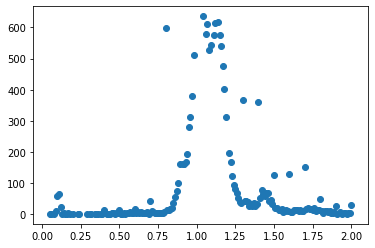

In [636]:
p = df_grid.groupby('trip_distance', as_index=False).count()
# p = df_grid
p = p[(p.trip_distance >= 0.05) & (p.trip_distance <= 2)]
series = p.trip_distance
samples = p.time_of_day
plt.scatter(series, samples)
blacklist = p.sort_values('pickup_datetime').tail(10)[['trip_distance']].values
series.mean(), series.std()

In [594]:
def dist(x, y):
    return sqrt((x[0] - y[0]) ** 2 + (x[1] - y[1]) ** 2)

def k_neigs(x, data, k):
    return sorted(data, key=lambda y: dist(x, y))[1:k + 1]

ros = {}
def ro(x, data, k):
    if x not in ros:
        k_neigs_ = k_neigs(x, data, k)
        r = sum([(1 / dist(x, _)) for _ in k_neigs_])
        ros[x] = r
    return ros[x]

def ro_n(x, data, k):
    k_neigs_ = k_neigs(x, data, k)
    ro_x = ro(x, data, k)
    k_ros = [ro(_, data, k) for _ in k_neigs_]
    return ro_x / (sum(k_ros) / len(k_ros))

data = list(zip(p.trip_distance, p.time_of_day))
ross = []
for x in data:
    ross.append((x, ro(x, data, 5)))

In [593]:
xx = (0.79, 8)
print(k_neigs(xx, data, 5))
for _ in k_neigs(xx, data, 5):
    print(ro(_, data, 5))
print()
print(ro(xx, data, 5))
print(ro_n(xx, data, 5))

[(1.61, 8), (1.62, 8), (0.72, 7), (0.71, 9), (0.68, 7)]
104.21383215141368
104.19978404843754
34.85151710282066
4.898206999376283
37.22467853146033

5.412710073843569
0.09483071671977357


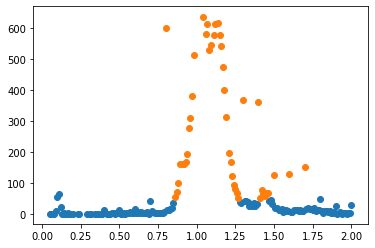

In [611]:
data = list(zip(p.trip_distance, p.time_of_day))
g = GaussianMixture(2)
g.fit(data)
data_t = g.predict(data)
clusters = {}
for index, tag in enumerate(data_t):
    if tag not in clusters:
        clusters[tag] = []
    clusters[tag].append(data[index])
for i in clusters:
    plt.scatter([_[0] for _ in clusters[i]], [_[1] for _ in clusters[i]])

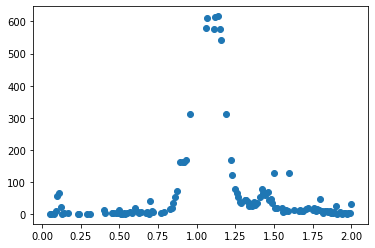

In [596]:
th = 100
plt.scatter([x[0] for x, s in ross if s < th and s > .5], [x[1] for x, s in ross if s < th and s > .5])

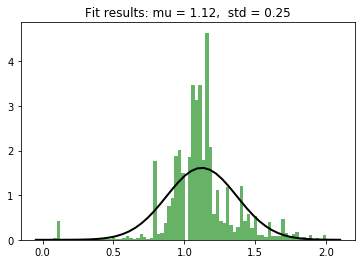

In [651]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

data = df_grid.trip_distance

mu, std = norm.fit(data)

# Plot the histogram.
vals = plt.hist(data, bins=80, density=True, alpha=0.6, color='g')

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 50)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

plt.show()

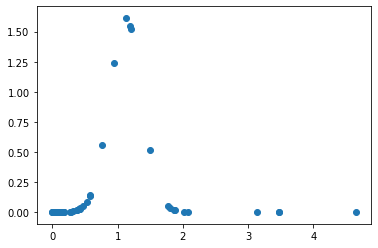

In [709]:
data_f = []
xx = []
yy = []
for a, b in list(zip(vals[0], vals[1])):
    likelihood = norm.pdf(a, mu, std)
#     print (a, b, likelihood)
#     if likelihood - a == 0:
    data_f.append(b)
    xx.append(a)
    yy.append(likelihood)
        
plt.scatter(xx, yy)
# plt.scatter(vals[1][:80], vals[0][:80])
# plt.hist(data, bins=25, density=True, alpha=0.6, color='g')
# plt.plot(x, p, 'k', linewidth=2)

In [683]:
vals

(array([8.75244795e-03, 3.50097918e-02, 4.23034984e-01, 2.04223786e-02,
        1.45874133e-02, 5.83496530e-03, 5.83496530e-03, 8.75244795e-03,
        0.00000000e+00, 2.91748265e-03, 5.83496530e-03, 8.75244795e-03,
        8.75244795e-03, 5.83496530e-03, 4.95972051e-02, 1.16699306e-02,
        2.62573439e-02, 2.04223786e-02, 5.25146877e-02, 1.75048959e-02,
        2.62573439e-02, 3.20923092e-02, 8.16895142e-02, 2.91748265e-02,
        2.62573439e-02, 4.37622398e-02, 1.22534271e-01, 5.83496530e-02,
        2.62573439e-02, 4.08447571e-02, 1.76799449e+00, 1.19616789e-01,
        1.63379028e-01, 3.70520297e-01, 7.61462972e-01, 9.42346896e-01,
        1.87302386e+00, 2.01598051e+00, 1.49375112e+00, 0.00000000e+00,
        1.85551897e+00, 3.47472184e+00, 3.12754140e+00, 3.47180435e+00,
        1.79716931e+00, 4.64463238e+00, 2.08016513e+00, 5.77661565e-01,
        1.12614830e+00, 4.28869950e-01, 3.70520297e-01, 1.19325040e+00,
        3.20923092e-01, 1.72131476e-01, 2.88830782e-01, 1.207837

In [ ]:
# EM
def norm_pdf(mean, std, x):
    res = 1 / (std * math.sqrt(2 * math.pi))
    exponent = (((x - mean) / std) ** 2)
    res = res * math.exp(-0.5 * exponent)
    return res

def uni_pdf(a, b, x):
    if a <= x <= b:
        return 1 / (b - a)
    return 0

lamda = 0.5
mu = 10.
sigma = 2.
a = 0
b = 20
for x in data:
    norm_x = lamda * norm_pdf(mean, std, x)
    uni_x = (1-lamda) * uni_pdf()

In [497]:
norm.fit(data)

(11.218311762195988, 2.471689147587303)

In [447]:
df_grid = df_grid[(df_grid.trip_distance >= 0.05) & (df_grid.trip_distance <= 2)]# & (df_grid.trip_distance.apply(lambda x: x not in blacklist))]

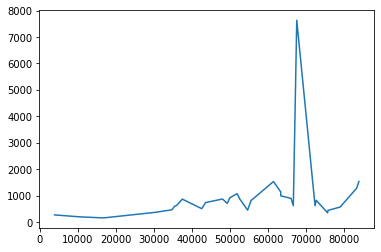

In [279]:
df_grid = df_grid.merge(weather, on=['DATE'], )

g = df_grid[df_grid.DATE == '2013-11-01'].reset_index(drop=True)
plt.plot(g.pickup_datetime.apply(lambda d: d.timestamp() % (24 * 60 * 60)), g.trip_time_in_secs / g.trip_distance)

## Analyze by Connected components - not really doing anything

In [23]:
g = nx.Graph()
edges = [(f'{row[0]}_{row[1]}', f'{row[2]}_{row[3]}', row[4]) for row in df.values]
g.add_weighted_edges_from(edges)

In [36]:
import itertools
for i, comp in enumerate(nx.algorithms.connected_components(g)):
    print(f'******* Component {i} **********')
    print(f'Component size: {len(comp)}')
    
    distances = [coordinates_distance(*(x.split('_', 1) + y.split('_', 1))) 
                 for x, y in list(itertools.product(comp, comp))]
    depth = max(distances)
    print(f'Component depth: {depth}km')
    
## the largeset component's data is really far away from each other, hence it is not usable

******* Component 0 **********
Component size: 10
Component depth: 0.09176355391575176km
******* Component 1 **********
Component size: 4
Component depth: 0.029003338518161913km
******* Component 2 **********
Component size: 3
Component depth: 0.04244682175196422km
******* Component 3 **********
Component size: 4
Component depth: 0.09065483659090774km
******* Component 4 **********
Component size: 2
Component depth: 0.04846937214987653km
******* Component 5 **********
Component size: 3
Component depth: 0.0650748814414627km
******* Component 6 **********
Component size: 2
Component depth: 0.038912677669168484km
******* Component 7 **********
Component size: 2
Component depth: 0.017460071780791512km
******* Component 8 **********
Component size: 3
Component depth: 0.048821449082078035km
******* Component 9 **********
Component size: 6
Component depth: 0.0401894279075165km
******* Component 10 **********
Component size: 3
Component depth: 0.0418487378196112km
******* Component 11 ********